# **Artificial Reverberator**
programmed for Intelligent Multimedia Systems class

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 1. Read input files

In [13]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import numpy as np

from tqdm import tqdm

xin, fs = librosa.load('/content/drive/MyDrive/test.wav',sr=44100)
print(xin.shape)

ipd.Audio(xin, rate=fs, autoplay=False)

(470529,)


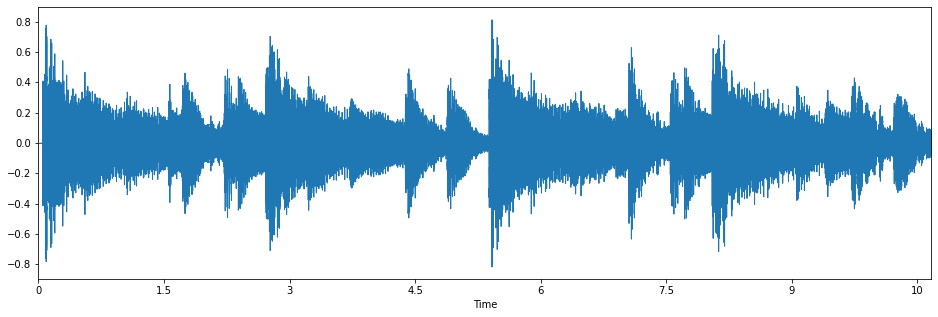

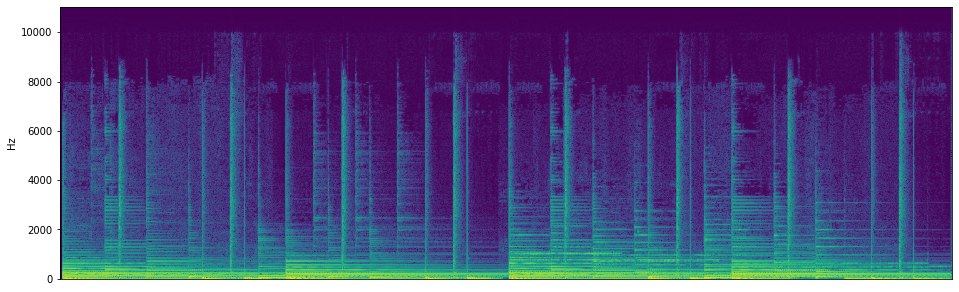

In [3]:
plt.figure(figsize = (16,5))            # 그래프의 사이즈를 지정. (16,10) 정도로 지정해 주겠습니다.
librosa.display.waveplot(y=xin, sr=fs)   # audio와 sample rate을 input값으로 받는 함수. 그래프를 나타내기 위함.
plt.show()                               # 그래프를 show(보여주는) 함수

stft = librosa.stft(xin, n_fft=1024, hop_length=256) #librosa를 이용한 stft
spectrogram, phase = librosa.magphase(stft)
#stft를 바탕으로 magnitude spectrogram과 이에 대한 phase(위상)을 얻을 수 있는 함수입니다. 여기서는 magnitude spectrogram만을 사용합니다.

plt.figure(figsize=(16,5))
librosa.display.specshow(np.log(spectrogram + 1e-3), cmap='viridis', x_axis=None, y_axis='linear')
# specshow는 spectrogram을 input으로 받아 시각화해주는 함수입니다. cmap 은 colormap의 약자로서, 시각화 해주는 색깔을 설정합니다.
# spectrogram 시각화를 더 분명하게 하기 위해, spectrogram에 1e-3(0.001)을 더하고 로그(np.log) 함수를 취합니다. 
plt.show()

# 2. Function definition (Comb filter & all-pass filter)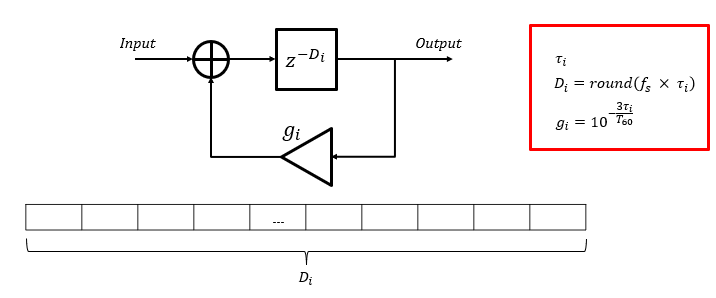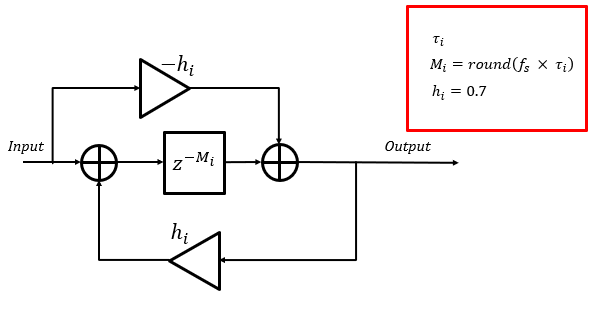

In [14]:
def combfilter(input, gain, mem_length):
  mdelay = np.zeros(int(mem_length+1))
  out = np.zeros(len(input))
  
  for nn in tqdm(range(0,len(input))):
    out[nn] = mdelay[-1]
    mdelay = np.hstack((0.0, mdelay[:-1]))
    mdelay[0] = input[nn] + gain* mdelay[-1]
  return out

def allpassfilter(input, gain, mem_length):
  mdelay = np.zeros(int(mem_length+1))
  out = np.zeros(len(input))

  for nn in tqdm(range(0,len(input))):
    mdelay[-1] = mdelay[-1] + (-1)*gain*input[nn]
    out[nn] = mdelay[-1]
    mdelay = np.hstack((0.0, mdelay[:-1]))
    mdelay[0] = input[nn] + gain* mdelay[-1]
  return out 

# 2. Set the reverberation time

In [76]:
T60 = 10

# 3. Comb filter delays in msec

In [77]:
comb_delay1 = 30
comb_delay2 = 37
comb_delay3 = 41
comb_delay4 = 44

# 4. All-pass filter delays in msec

In [78]:
apf_delay1 = 1.7
apf_delay2 = 1.7

# 5. Set the memory lengths corresponding to the delays

In [79]:
comb_mem_len1 = np.round(comb_delay1/1000*fs)
comb_mem_len2 = np.round(comb_delay2/1000*fs)
comb_mem_len3 = np.round(comb_delay3/1000*fs)
comb_mem_len4 = np.round(comb_delay4/1000*fs)
apf_mem_len1 = np.round(apf_delay1/1000*fs)
apf_mem_len2 = np.round(apf_delay2/1000*fs)

# 6. Set the (feedback) gains of the combfilters

In [80]:
comb_g1 = 10**(-3*(comb_delay1/1000)/T60)
comb_g2 = 10**(-3*(comb_delay2/1000)/T60)
comb_g3 = 10**(-3*(comb_delay3/1000)/T60)
comb_g4 = 10**(-3*(comb_delay4/1000)/T60)

# 7. Set the gain of the all-pass filters

In [81]:
h1 = 0.7
h2 = 0.7

# 8. Set the mixing gain

In [82]:
gr = 0.25
gs = 1.0

# 9. Comb filter output (yc1, yc2, yc3, yc4) & sum of all outputs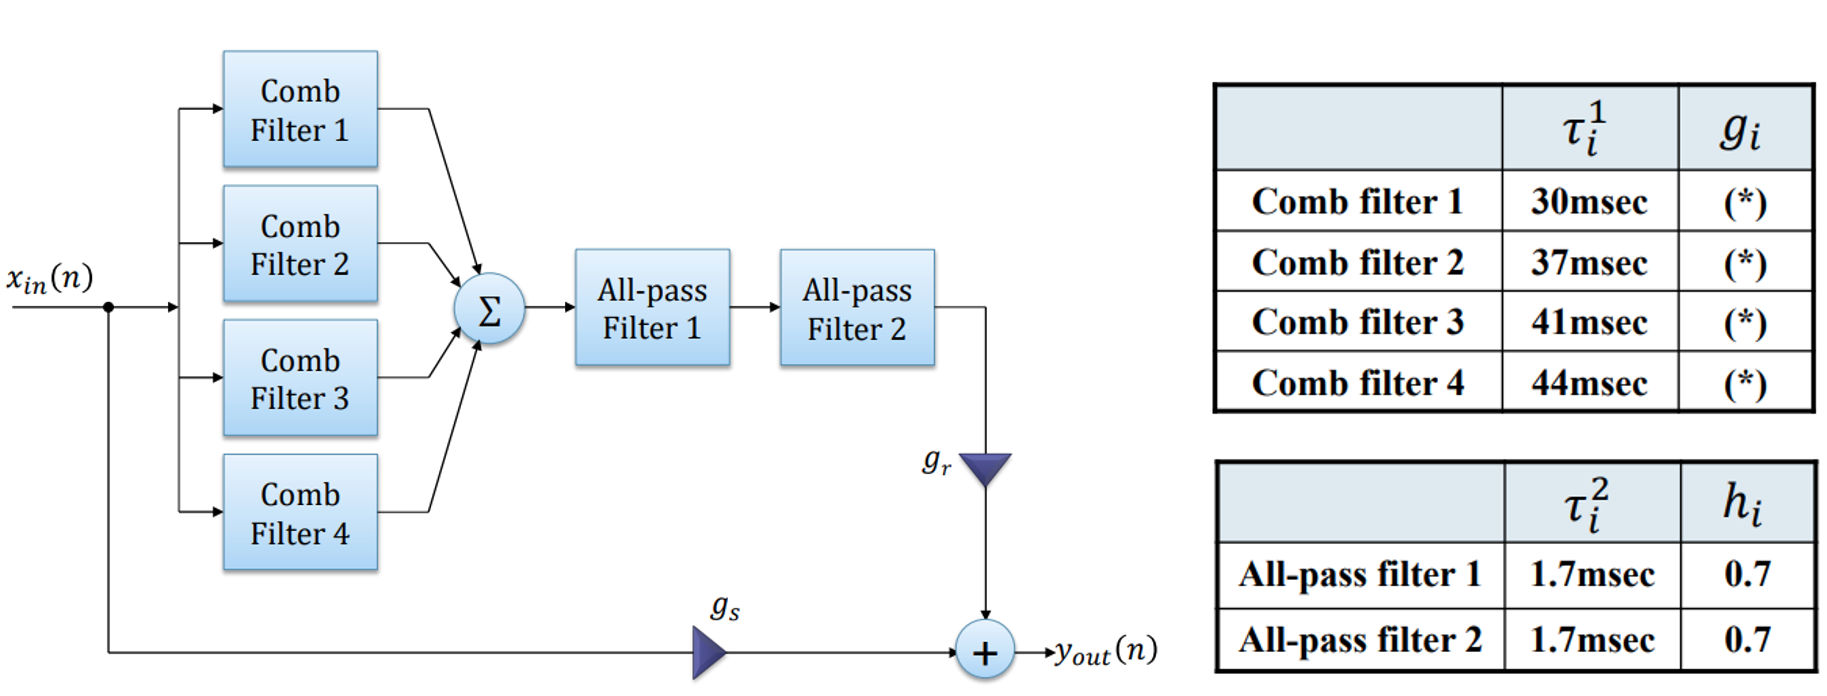

In [83]:
yc1 = combfilter(xin, comb_g1,comb_mem_len1)
yc2 = combfilter(xin, comb_g2,comb_mem_len2)
yc3 = combfilter(xin, comb_g3,comb_mem_len3)
yc4 = combfilter(xin, comb_g4,comb_mem_len4)

ycall = yc1 + yc2 + yc3 +yc4

100%|██████████| 470529/470529 [00:07<00:00, 63863.31it/s]


# 10. All-pass filter output (ya1, ya2)

In [84]:
ya1 = allpassfilter(ycall,h1,apf_mem_len1)
ya2 = allpassfilter(ya1,h2,apf_mem_len2)

100%|██████████| 470529/470529 [00:05<00:00, 84190.39it/s]


# 11. Make direct sound + reverberated sound (yout)

In [85]:
yout = gs * xin + gr * ya2

ipd.Audio(yout, rate=fs, autoplay=False)

# 12. Confirm results

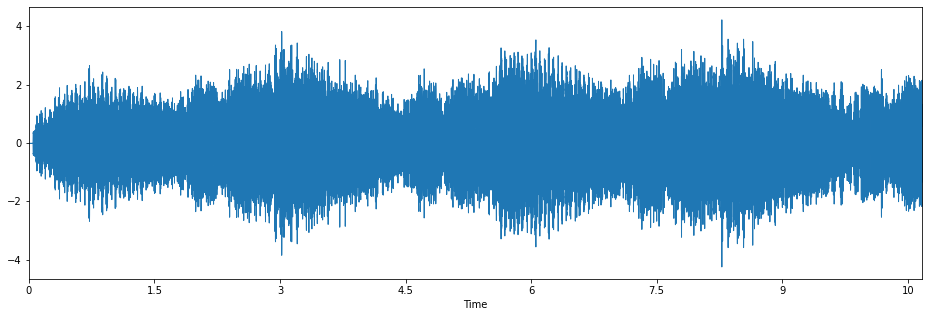

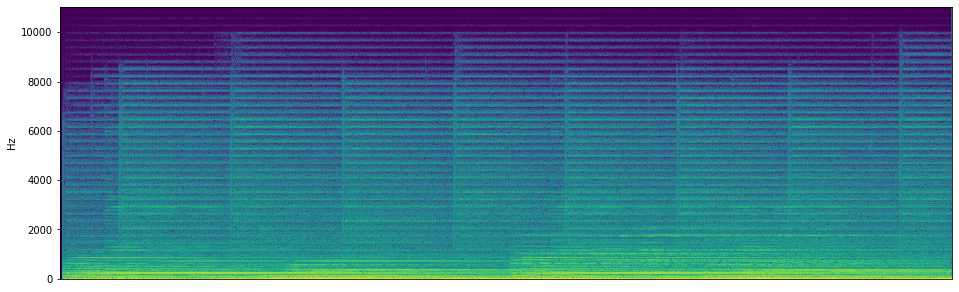

In [86]:
plt.figure(figsize = (16,5))            # 그래프의 사이즈를 지정. (16,10) 정도로 지정해 주겠습니다.
librosa.display.waveplot(y=yout, sr=fs)   # audio와 sample rate을 input값으로 받는 함수. 그래프를 나타내기 위함.
plt.show()                               # 그래프를 show(보여주는) 함수

stft = librosa.stft(yout, n_fft=1024, hop_length=256) #librosa를 이용한 stft
spectrogram, phase = librosa.magphase(stft)
#stft를 바탕으로 magnitude spectrogram과 이에 대한 phase(위상)을 얻을 수 있는 함수입니다. 여기서는 magnitude spectrogram만을 사용합니다.

plt.figure(figsize=(16,5))
librosa.display.specshow(np.log(spectrogram + 1e-3), cmap='viridis', x_axis=None, y_axis='linear')
# specshow는 spectrogram을 input으로 받아 시각화해주는 함수입니다. cmap 은 colormap의 약자로서, 시각화 해주는 색깔을 설정합니다.
# spectrogram 시각화를 더 분명하게 하기 위해, spectrogram에 1e-3(0.001)을 더하고 로그(np.log) 함수를 취합니다. 
plt.show()